## <font color=purple>Import needed modules</font>

In [1]:
#general libraries always needed
import pandas as pd
import numpy as np
import math

#plotting required modules
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter

#sklearn clustering / unsupervised learning modules
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

#sklearn modules for preprocessing and transformation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## <font color=purple>Function Definitions</font>

In [2]:
#function to create an Avg. Distance to Nearest Neighbor plt
def nn_avg_distance(X):
    plt.figure(figsize=(10,5))
    nn = NearestNeighbors(n_neighbors=15).fit(X)
    distances, idx = nn.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.xlabel("Instances", fontsize=14)
    plt.ylabel("Distances", fontsize=14)
    plt.title("Average Distance to Nearest Neighbor")
    plt.show()

In [3]:
#function to create a silhouette diagram
#requires the model, the independent value (i.e. X) used to fit the model, and a list of k values to plot

def inertia_silhouette_plot( X, k_values): 

    #iterate through different k values and collect inertia values and silhouette scores
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, max(k_values)+1)]
    inertias = [model.inertia_ for model in kmeans_per_k]
    silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]    
    
    #print the silhouette scores and k values
    plt.plot(inertias)
    plt.ylabel("Inertia", fontsize=14)
    plt.xlabel("k Value", fontsize=14)
    plt.show()
    print("-"*80)
    #create the plot's figure
    plt.figure(figsize=(10, len(k_values)*3))

    ct = 0 #temp counter variable

    #build a subplot for each value of k
    for k in k_values:
    
        #create the subplot
        ct +=1
        plt.subplot(math.ceil(len(k_values)/2), 2, ct)
    
        #get the predictions and silhouette value
        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(X, y_pred)

        #create the bars for each cluster
        padding = len(X) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

       #plot the silhouette line
        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        
        #chart title
        plt.title("k={} --- {:.2}".format(k, silhouette_scores[k - 2]), fontsize=16)
 
        #add a y label for each row and an x axis label for the last 2 graphs
        if ct%2 == 1:
            plt.ylabel("Cluster")
        if ct == len(k_values) or ct==len(k_values)-1:
            #plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
                
    #plot
    plt.show()

In [4]:
#function to create a 2 dimmensional representation of data using tSNE
#needs the independent data as well as Y label data OR prediction
def tsne_plot(X, y):
    X_tsne = TSNE(learning_rate=1000, perplexity=25, init="random").fit_transform(X)
    plt.figure(1, facecolor='white', figsize=(10, 12))
    a=plt.scatter(
        X_tsne[(y!=-1), 0],
        X_tsne[(y!=-1), 1],
        s=100,
        alpha=0.90,
        c=y[y!=-1],
        cmap=cm.Paired
    )
    plt.legend(handles=a.legend_elements()[0],labels=a.legend_elements()[1])
    #plt.scatter(
        #X_tsne[(y==-1), 0],
        #X_tsne[(y==-1), 1],
        #s=100,
        #alpha=0.05
    #)
    plt.title('T-SNE Plot')
    plt.show()

In [5]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")## <font color=blue>Source data</font>

## <font color=purple>Source Data</font>

In [6]:
#download data files if not currently downloaded into the current working directory
path = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename = "sephora_website_dataset.csv"


path2 = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename2 = "product_info.csv"


downloadDataResource(filename, path)
downloadDataResource(filename2, path2)

Data resource sephora_website_dataset.csv already downloaded.
Data resource product_info.csv already downloaded.


In [7]:
#create a dataframe with the data from the CSV file
df = pd.read_csv(filename)
df2 = pd.read_csv(filename2)

## <font color=purple>Transform Data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9168 non-null   int64  
 1   brand                   9168 non-null   object 
 2   category                9168 non-null   object 
 3   name                    9168 non-null   object 
 4   size                    9168 non-null   object 
 5   rating                  9168 non-null   float64
 6   number_of_reviews       9168 non-null   int64  
 7   love                    9168 non-null   int64  
 8   price                   9168 non-null   float64
 9   value_price             9168 non-null   float64
 10  URL                     9168 non-null   object 
 11  MarketingFlags          9168 non-null   bool   
 12  MarketingFlags_content  9168 non-null   object 
 13  options                 9168 non-null   object 
 14  details                 9168 non-null   

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [10]:
df2.rename(columns = {'product_name':'name'}, inplace = True)
#df2.rename(columns = {'rating':'2023ratings'}, inplace = True)

In [11]:
df["cat_rating"] = ["1.0" if x == 1.0 else "1.5" if x == 1.5 else "2.0" if x == 2.0 else "2.5" if x == 2.5 else "3.0" if x == 3.0 else "3.5" if x == 3.5 else "4.0" if x == 4.0 else "4.5" if x == 4.5 else "5" for x in df["rating"]]

In [12]:
df = pd.merge(df,df2[['name',"secondary_category"]],on='name', how='left')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9232 entries, 0 to 9231
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9232 non-null   int64  
 1   brand                   9232 non-null   object 
 2   category                9232 non-null   object 
 3   name                    9232 non-null   object 
 4   size                    9232 non-null   object 
 5   rating                  9232 non-null   float64
 6   number_of_reviews       9232 non-null   int64  
 7   love                    9232 non-null   int64  
 8   price                   9232 non-null   float64
 9   value_price             9232 non-null   float64
 10  URL                     9232 non-null   object 
 11  MarketingFlags          9232 non-null   bool   
 12  MarketingFlags_content  9232 non-null   object 
 13  options                 9232 non-null   object 
 14  details                 9232 non-null   

In [14]:
df.head()

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,cat_rating,secondary_category
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0,4.0,NaN
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0,4.5,Men
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0,4.5,Women
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0,4.5,Women
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0,3.5,NaN


In [15]:
df.name.str.split().explode().value_counts().head(10)

Mini     665
&        629
Cream    530
Set      464
Lip      404
Mask     402
de       400
Eau      400
Brush    393
Oil      387
Name: name, dtype: int64

In [16]:
df["mini"] = [1 if "Mini" in x else 0 for x in df["name"]]
df["cream"] = [1 if "Cream" in x else 0 for x in df["name"]]
df["set"] = [1 if "Set" in x else 0 for x in df["name"]]
df["mask"] = [1 if "Mask" in x else 0 for x in df["name"]]
df["eau"] = [1 if "Eau" in x else 0 for x in df["name"]]
df["lip"] = [1 if "Lip" in x else 0 for x in df["name"]]
df["brush"] = [1 if "Brush" in x else 0 for x in df["name"]]
df["oil"] = [1 if "Oil" in x else 0 for x in df["name"]]

In [17]:
df.ingredients.str.split().explode().value_counts().head(20)

Extract-         17337
the              17179
that             14600
of               14080
and              13214
Oil-             12294
Sodium           11416
(Ci              11147
-                10386
to               10238
Glycol-           7869
Acid-             7759
Seed              7295
or                7005
are               6973
is                6933
methacrylate-     6591
Ci                5710
be                5522
products          5429
Name: ingredients, dtype: int64

In [18]:
df["extract"] = [1 if "Extract-" in x else 0 for x in df["name"]]
df["oil"] = [1 if "Oil- " in x else 0 for x in df["name"]]
df["sodium"] = [1 if "Sodium" in x else 0 for x in df["name"]]
df["glycol"] = [1 if "Glycol-" in x else 0 for x in df["name"]]
df["acid"] = [1 if "Acid-" in x else 0 for x in df["name"]]
df["seed"] = [1 if "Seed" in x else 0 for x in df["name"]]
df["metha"] = [1 if "methacrylate- " in x else 0 for x in df["name"]]

In [19]:
df = df.drop(columns = ["id","rating","name","size","value_price","URL","MarketingFlags","MarketingFlags_content","options","details","how_to_use","ingredients"])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9232 entries, 0 to 9231
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brand               9232 non-null   object 
 1   category            9232 non-null   object 
 2   number_of_reviews   9232 non-null   int64  
 3   love                9232 non-null   int64  
 4   price               9232 non-null   float64
 5   online_only         9232 non-null   int64  
 6   exclusive           9232 non-null   int64  
 7   limited_edition     9232 non-null   int64  
 8   limited_time_offer  9232 non-null   int64  
 9   cat_rating          9232 non-null   object 
 10  secondary_category  2468 non-null   object 
 11  mini                9232 non-null   int64  
 12  cream               9232 non-null   int64  
 13  set                 9232 non-null   int64  
 14  mask                9232 non-null   int64  
 15  eau                 9232 non-null   int64  
 16  lip   

In [21]:
#df.secondary_category.fillna("Unknown")

In [22]:
cat_attribs = ["brand", "category","secondary_category"]

#set the numerical attributes
num_attribs = list(df.drop(cat_attribs,axis=1) )

num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), #because no missing values, not used
 ('std_scaler', StandardScaler()),   
])

#define the column transformation process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse = False), cat_attribs)      #because no categorical attributes, not used 
])

### Create X data set

In [23]:
X = full_pipeline.fit_transform( df )
X.shape

(9232, 530)

## <font color=purple>K-Means

To determine an ideal <i>k</i> value, need to look where there is low inertia (mean square error between each instance & centroid) and a high (close to 1) silhouette coefficient (proximity to cluster boundries)

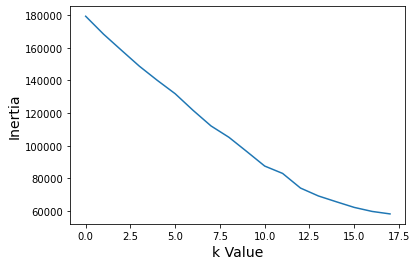

--------------------------------------------------------------------------------


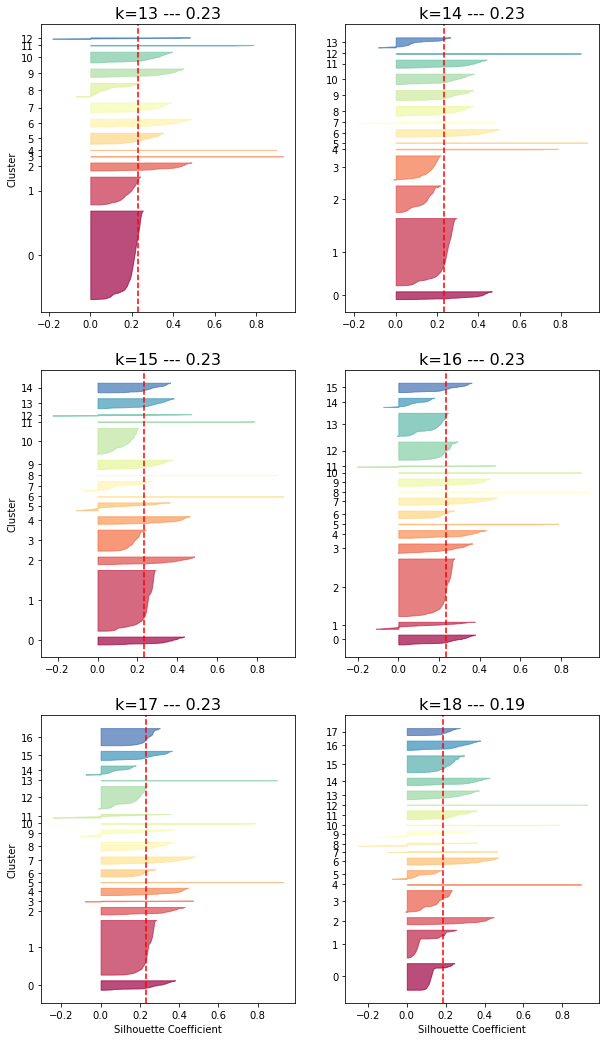

In [24]:
#use this function to evaluate your X data across different k values
#NOTE: this function can take a little time especially if your k value list has numbers > 20
inertia_silhouette_plot(X, [13, 14, 15, 16, 17, 18])

In [25]:
k = 14

#create the model
kmeans = KMeans(n_clusters=k, random_state=42)

#fit the model and predict y values (i.e. cluster value)
y_pred = kmeans.fit_predict(X)

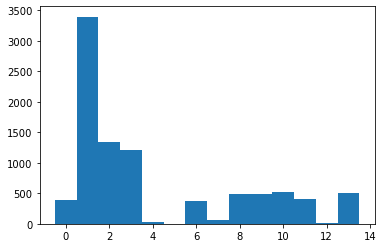

In [26]:
#plot the number of instances in each of the created clusters
plt.hist(y_pred, bins=range(k+1), align='left')
plt.show()

In [27]:
#save the predictions of each instance to a column called KMeans
df[ "KMeans"] = y_pred

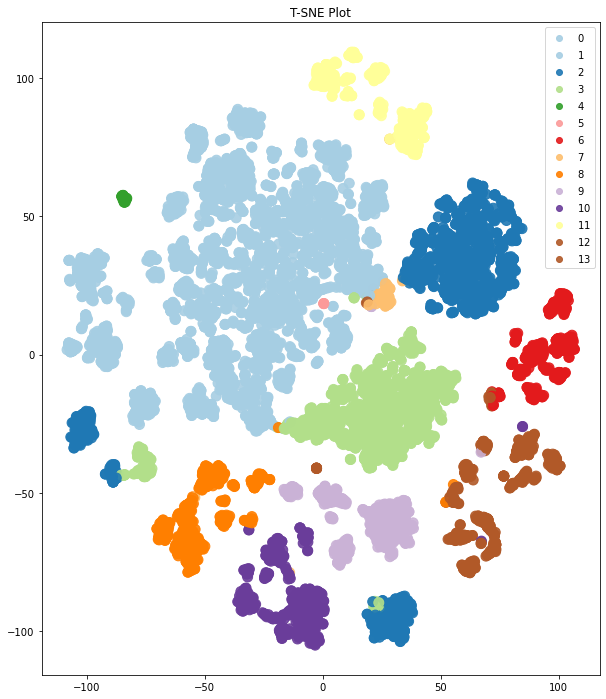

In [29]:
#plot Kmeans results on a 2-dimensional tSNE of the same data set
tsne_plot(X, df.KMeans)

In [30]:
df[y_pred==11].category.value_counts()
#no dominant category type

Face Masks                   213
Hair Masks                    60
Sheet Masks                   44
Eye Masks                     15
Mini Size                     11
Lip Balms & Treatments         9
Hair                           5
Hand Cream & Foot Cream        5
Skincare                       4
Color Care                     4
Value & Gift Sets              4
Lip Balm & Treatment           4
Face Wash & Cleansers          3
no category                    3
Night Creams                   3
Eye Creams & Treatments        2
Blemish & Acne Treatments      2
Moisturizers                   2
Spa Tools                      1
Face Serums                    1
Scalp & Hair Treatments        1
Exfoliators                    1
Anti-Aging                     1
Body Lotions & Body Oils       1
Face Wash                      1
Shampoo                        1
Moisturizer & Treatments       1
Name: category, dtype: int64

In [44]:
cluster=df[y_pred==11]

In [45]:
cluster.cat_rating.value_counts()
#mostly high ratings

4.5    195
4.0    122
3.5     34
5       31
3.0     15
2.0      3
1.5      1
2.5      1
Name: cat_rating, dtype: int64

In [46]:
cluster.price.value_counts()
#moderately priced
#lower end pricing is face masks

6.0     32
25.0    16
8.0     15
38.0    14
62.0    13
        ..
43.0     1
80.0     1
77.0     1
40.0     1
11.0     1
Name: price, Length: 80, dtype: int64

In [47]:
cluster.exclusive.value_counts()
#not entirely exclusive to sephora; 37.5% is exclusive

0    250
1    152
Name: exclusive, dtype: int64

In [48]:
cluster.limited_edition.value_counts()
#mainly not limited edition

0    385
1     17
Name: limited_edition, dtype: int64

In [52]:
cluster['mask'].value_counts()
#all masks in the names for this cluster

1    402
Name: mask, dtype: int64

In [54]:
cluster['brand'].value_counts()
#mainly sephora collection or skincare brands

SEPHORA COLLECTION    56
Dr. Jart+             17
Kérastase             16
Fresh                 16
GLAMGLOW              14
                      ..
The INKEY List         1
Indie Lee              1
philosophy             1
FARSÁLI                1
Fable & Mane           1
Name: brand, Length: 101, dtype: int64

## <font color=purple>DBSCAN 

#### Requires the use of an Epsilon value

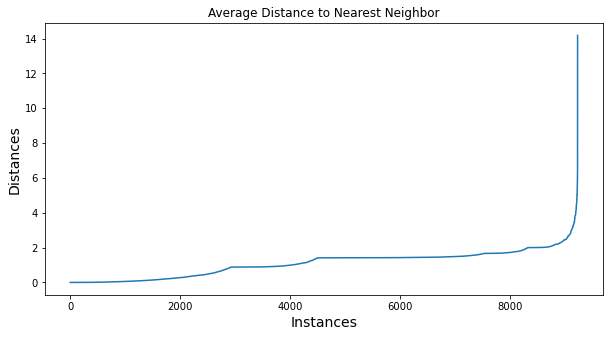

In [55]:
#But how to determine a good epsilon?
#one method is to review the Avg. Distances to Nearest Neighbor graph and find its "elbow point"
nn_avg_distance(X)

In [58]:
#And then once you know the range for your epsilon, use a loop to try out a few values
for epsilon in np.arange(2,7,.5):
    dbscan = DBSCAN(eps=epsilon, min_samples=25)      #epsilon defines the neighborhood distance
    dbscan.fit(X)
    print(epsilon, "-", set(list(dbscan.labels_)))

2.0 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, -1}
2.5 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
3.0 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
3.5 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
4.0 - {0, 1, 2, 3, 4, 5, 6, 7, -1}
4.5 - {0, 1, 2, 3, -1}
5.0 - {0, -1}
5.5 - {0, 1, -1}
6.0 - {0, 1, -1}
6.5 - {0, 1, -1}


In [61]:
#create and fit the model
dbscan = DBSCAN(eps=2.0, min_samples=25)      #epsilon defines the neighborhood distance
dbscan.fit(X)

DBSCAN(eps=2.0, min_samples=25)

In [62]:
y_pred=dbscan.labels_
clusters = set(list(y_pred))
len(clusters)

25

In [63]:
#save the predictions of each instance to a column called DBSCAN
df[ 'DBSCAN' ] = y_pred

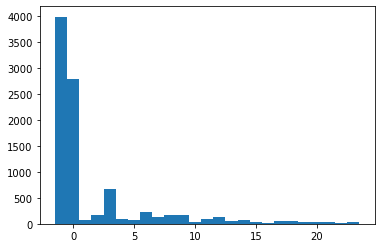

In [64]:
#plot the number of instances in each of the created clusters
plt.hist(y_pred, bins=range(-1,len(clusters)), align='left' )
plt.show()

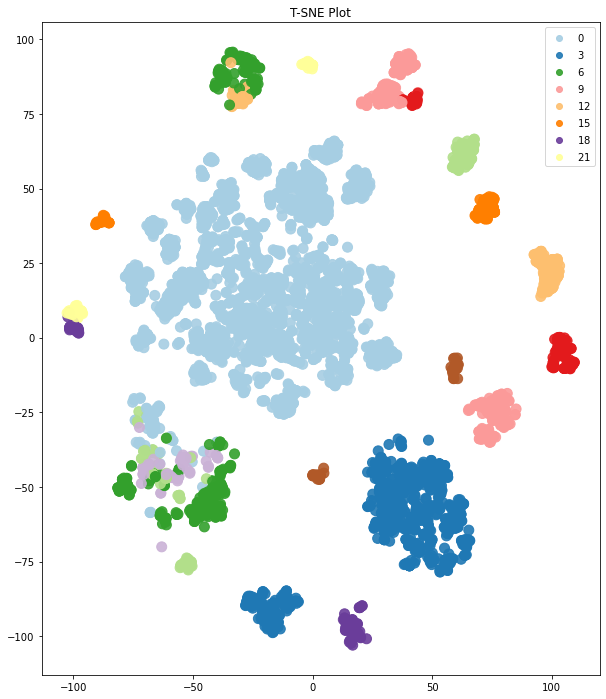

In [65]:
#plot DBSCAN results on a 2-dimensional tSNE of the same data set
tsne_plot(X, y_pred)

In [67]:
df[y_pred==9]
#all lip products

,brand,category,number_of_reviews,love,price,online_only,exclusive,limited_edition,limited_time_offer,cat_rating,...,brush,oil,extract,sodium,glycol,acid,seed,metha,KMeans,DBSCAN
299,Anastasia Beverly Hills,Lipstick,818,112900,18.0,0,0,0,0,4.5,...,0,0,0,0,0,0,0,0,8,9
390,Armani Beauty,Lipstick,367,18600,38.0,0,0,0,0,4.5,...,0,0,0,0,0,0,0,0,8,9
397,Armani Beauty,Lip Gloss,128,47800,38.0,0,0,0,0,4.5,...,0,0,0,0,0,0,0,0,8,9
405,Armani Beauty,Lipstick,388,18800,38.0,0,0,0,0,4.5,...,0,0,0,0,0,0,0,0,8,9
411,Armani Beauty,Lipstick,357,58200,38.0,0,0,0,0,4.5,...,0,0,0,0,0,0,0,0,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8500,trèStiQue,Lipstick,57,3600,25.0,0,0,0,0,3.5,...,0,0,0,0,0,0,0,0,8,9
8572,Urban Decay,Lip Gloss,461,37300,20.0,0,0,0,0,4.0,...,0,0,0,0,0,0,0,0,8,9
8932,Yves Saint Laurent,Lipstick,180,73600,39.0,0,0,0,0,4.0,...,0,0,0,0,0,0,0,0,8,9
8964,Yves Saint Laurent,Lipstick,163,21600,39.0,0,0,0,0,4.5,...,0,0,0,0,0,0,0,0,8,9


In [70]:
df[ y_pred ==9].brand.value_counts()
#mostly higher end products

TOM FORD                   13
Charlotte Tilbury          13
CLINIQUE                   11
Givenchy                   11
Bobbi Brown                 9
bareMinerals                8
Hourglass                   7
Dior                        6
Gucci                       6
Shiseido                    5
Marc Jacobs Beauty          5
NARS                        5
NUDESTIX                    5
Guerlain                    5
Smashbox                    4
Natasha Denona              4
Too Faced                   4
Lancôme                     4
Laura Mercier               4
Armani Beauty               4
lilah b.                    3
Yves Saint Laurent          3
Kosas                       3
tarte                       2
MILK MAKEUP                 2
Kiehl's Since 1851          2
KEVYN AUCOIN                2
Jouer Cosmetics             2
IT Cosmetics                2
ILIA                        2
BECCA                       2
Urban Decay                 1
trèStiQue                   1
Tower 28 B

In [71]:
df[ y_pred ==9].cat_rating.value_counts()
#mostly 4-4.5 stars

4.5    83
4.0    59
3.5    17
5       6
3.0     3
Name: cat_rating, dtype: int64

In [73]:
df[ y_pred ==9].price.value_counts()
#higher end products

26.0    15
38.0    15
34.0    14
29.0    11
55.0     9
22.0     9
20.0     8
30.0     8
25.0     7
32.0     7
28.0     7
19.5     6
24.0     5
21.0     4
37.0     4
42.0     4
18.0     3
33.0     3
39.0     3
27.0     3
16.0     3
47.0     2
18.5     2
17.5     2
36.0     2
46.0     2
45.0     1
35.0     1
17.0     1
31.0     1
15.0     1
19.0     1
57.0     1
23.0     1
14.0     1
40.0     1
Name: price, dtype: int64

In [75]:
df[ y_pred ==9].exclusive.value_counts()
#none are exclusive to Sephora

0    168
Name: exclusive, dtype: int64

In [77]:
df[ y_pred ==9].lip.value_counts()
#all have lip in the title

1    168
Name: lip, dtype: int64

In [81]:
df[ y_pred ==9].category.value_counts()

Lipstick                  97
Lip Gloss                 29
Lip Balm & Treatment      21
Lip Liner                 12
Lip Balms & Treatments     3
Lip Stain                  2
Blush                      1
Face Wash & Cleansers      1
Highlighter                1
Liquid Lipstick            1
Name: category, dtype: int64

## <font color=purple>Bayesian Guassian Mixture

In [82]:
# create a model and fit X

#set the k value to your best guess (or higher)
#n_init defines how many times to fit the model
bgm = BayesianGaussianMixture(n_components=10, n_init=10)  
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10)

In [83]:
#let's look at the weights to possible clusters and zero to all unneeded clusters
weights = np.round(bgm.weights_,2)
weights

array([0.16, 0.15, 0.  , 0.09, 0.17, 0.  , 0.08, 0.16, 0.19, 0.  ])

In [84]:
#calculate the ideal k value (or just count the values above)
k = len(set(list(weights)))
k

7

## <font color=purple>Gaussian Mixture

In [85]:
#Let's train a Gaussian Mixture on this dataset. 
k = 7
gauss = GaussianMixture(n_components=k, random_state=42)
y_pred = gauss.fit_predict(X)

In [86]:
#save the predictions of each instance to a column called Gauss
df['Gauss'] = y_pred

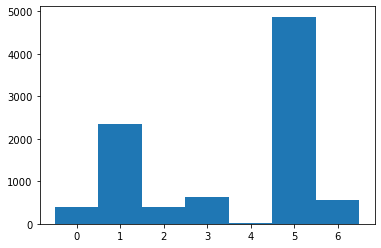

In [87]:
#plot the number of instances in each of the created clusters
plt.hist(y_pred, bins=range(k+1), align='left')
plt.show()

In [88]:
df[ "Gauss"].value_counts()

5    4872
1    2356
3     634
6     557
2     393
0     391
4      29
Name: Gauss, dtype: int64

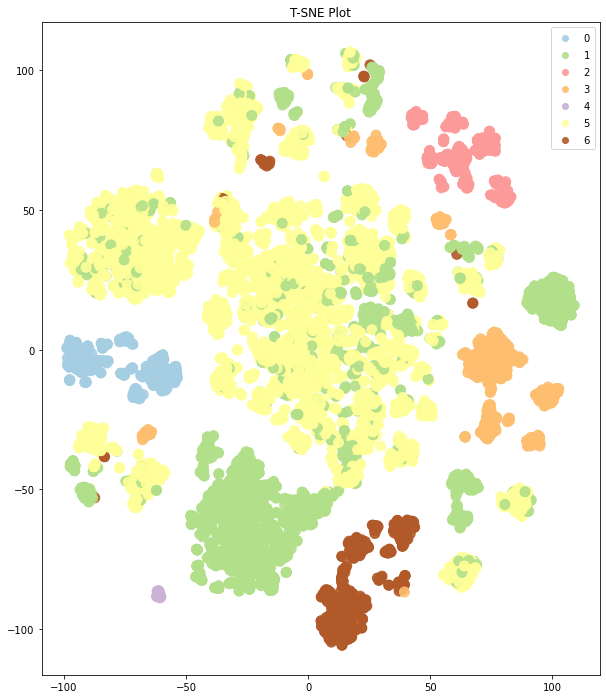

In [89]:
#plot Gaussian results on a 2-dimensional tSNE of the same data set
tsne_plot(X, df.Gauss)

In [90]:
df[y_pred==4]

,brand,category,number_of_reviews,love,price,online_only,exclusive,limited_edition,limited_time_offer,cat_rating,...,oil,extract,sodium,glycol,acid,seed,metha,KMeans,DBSCAN,Gauss
601,BeautyBio,Face Oils,9,2000,70.0,1,0,0,0,4.5,...,0,0,0,0,0,1,0,4,-1,4
975,boscia,Moisturizers,23,2500,38.0,0,0,0,0,4.5,...,0,0,0,0,0,1,0,4,-1,4
1022,Briogeo,Hair Styling Products,58,3500,26.0,0,0,0,0,4.0,...,0,0,0,0,0,1,0,4,-1,4
1482,Christophe Robin,Hair Masks,448,11900,71.0,0,0,0,0,3.5,...,0,0,0,0,0,1,0,4,-1,4
1506,Christophe Robin,Shampoo,21,2600,40.0,0,0,0,0,4.0,...,0,0,0,0,0,1,0,4,-1,4
2942,First Aid Beauty,Face Oils,326,18700,30.0,0,0,0,0,4.5,...,0,0,0,0,0,1,0,4,-1,4
3475,Herbivore,Face Oils,360,36600,48.0,0,0,0,0,4.5,...,0,0,0,0,0,1,0,4,-1,4
3533,High Beauty,Face Oils,74,6500,54.0,1,1,0,0,4.5,...,0,0,0,0,0,1,0,4,-1,4
3819,innisfree,Face Serums,607,8800,27.0,0,1,0,0,4.5,...,0,0,0,0,0,1,0,4,-1,4
3820,innisfree,Moisturizers,26,4600,24.0,0,1,0,0,5,...,0,0,0,0,0,1,0,4,-1,4


In [91]:
df[y_pred==4].seed.value_counts()
#all of these products have "seed" in the name

1    29
Name: seed, dtype: int64

In [92]:
df[y_pred==4].brand.value_counts()
#these are all brands that have "clean" products at sephora

Primera               9
innisfree             6
Christophe Robin      2
Kiehl's Since 1851    2
The Ordinary          2
BeautyBio             1
boscia                1
Briogeo               1
First Aid Beauty      1
Herbivore             1
High Beauty           1
MILK MAKEUP           1
Origins               1
Name: brand, dtype: int64

In [93]:
df[y_pred==4].category.value_counts()
#mostly treatments for your face

Face Oils                  7
Face Masks                 4
Face Serums                3
Eye Creams & Treatments    3
Sheet Masks                3
Moisturizers               2
Hair Styling Products      1
Hair Masks                 1
Shampoo                    1
Toners                     1
Mists & Essences           1
Value & Gift Sets          1
Face Wash & Cleansers      1
Name: category, dtype: int64

In [94]:
df[y_pred==4].cat_rating.value_counts()
#mostly 4.5 rating

4.5    17
4.0     6
3.5     3
5       3
Name: cat_rating, dtype: int64

In [95]:
df[y_pred==4].exclusive.value_counts()
#over half of these products are exclusive to sephora

1    17
0    12
Name: exclusive, dtype: int64

In [96]:
df[y_pred==4].price.value_counts()

6.0     3
26.0    2
30.0    2
28.0    2
24.0    2
70.0    1
45.0    1
22.0    1
74.0    1
58.0    1
7.7     1
9.8     1
50.0    1
20.0    1
25.0    1
38.0    1
19.0    1
27.0    1
54.0    1
48.0    1
40.0    1
71.0    1
64.0    1
Name: price, dtype: int64